In [44]:
import tensorflow as tf
from utls import plot
import numpy as np

Check the version of TF is 2.x

In [2]:
tf.__version__

'2.2.0'

Let's load up MNIST

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_test.shape

(10000, 28, 28)

Let's take a quick look at an image

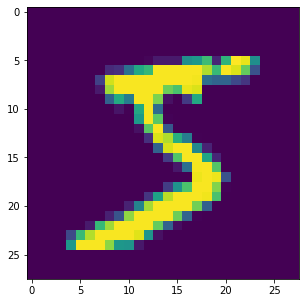

In [8]:
fig, ax = plot()
ax.imshow(x_train[0,...]) 

Let's create a fully-connected neural network with a single hidden layer, and a dropout rate of 0.2.

There should be:

- 28x28x128 + 128 = 100480 model parameters in the first layer (the +128 comes from the offset at each node)
- 128x10 + 10 = 1290 model parameters in the final layer

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


The model returns a vector of logits for each class, where a logit is defined as

$$\text{logit}(p)=\log\left(\frac{p}{1-p}\right)$$

where $p \in [0,1)$.

In [25]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.25631487,  0.01708113, -1.2543623 ,  0.6402714 , -0.04743747,
         0.05862472,  0.5954742 , -0.16391258,  1.0755765 , -0.23315321]],
      dtype=float32)

A softmax function is

$$\text{softmax}(\alpha) = \frac{1}{1+\exp(-\alpha)}$$

with the property $\text{softmax}(\text{logit}) = p$. 


We can pass the logits through a softmax to get a quantity $p_i$ for each class label $i \in [0,1,...,9]$. Hence people sometimes think of the output of a softmax as a "probability". However there is no model constraint in the neural networks forcing $\sum_i p_i = 1$, so we will also normalize them to give a quantity which may be interpreted as the model's confidence as to the classification of the input.

In [28]:
tf.nn.softmax(predictions).numpy()

array([[0.06254305, 0.08220788, 0.02305327, 0.15330684, 0.07707143,
        0.08569502, 0.14659068, 0.0685976 , 0.23692569, 0.06400856]],
      dtype=float32)

It is common to use [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) as a loss function for training classifiers. The purpose of using cross-entropy is to minimise the amount of information loss by the neural network for encoding the true probability distribution of the output. 

TensorFlow's sparse categorical cross-entropy loss takes a vector of logits for each sample

In [29]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The untrained model gives probabilities close to random, so the initial loss should be close to `-tf.log(1/10) ~= 2.3`

In [30]:
loss_fn(y_train[:1], predictions).numpy()

2.4569607

Let's compile the full model

In [31]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy']
             )

Fit the model for 5 epochs (i.e. pass the whole dataset through the neural net 5 times)

In [32]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3831 - accuracy: 0.8904
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3162 - accuracy: 0.9111
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3040 - accuracy: 0.9152
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2971 - accuracy: 0.9161
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2916 - accuracy: 0.9187


Check model performance on the test set

In [33]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.2872 - accuracy: 0.9225


[0.28716808557510376, 0.9225000143051147]

To generate a probability modelm we can wrap the trained model and attach a softmax to it:

In [34]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

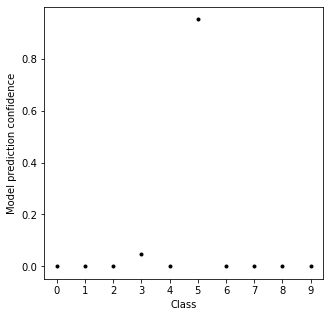

In [51]:
fig, ax = plot()
ax.plot(np.arange(10), np.ravel(probability_model(x_train[:1])), '.k')
ax.set_xticks(np.arange(10))
ax.set_xlabel('Class')
ax.set_ylabel('Model prediction confidence');

Cool!